In [48]:
# Importing packages
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import numpy as np
import itertools
from ipywidgets import Layout
import seaborn as sns
import math

import time
from scipy import linalg
import scipy.optimize as optimize
import sympy as sm

from tkinter import *
import tkinter as tk


In this project, we want to try to estimate the ratings of movies. That is, we well calculate the utility of a movie, given genres, duration, awards and so forth, and we will try to calculate the IMDB ratings for each movie, based on this utility. Finally, we will then minimize the distance between our estimated ratings and the actual ratings. 

Our utility function is given by: 
$$ U_i = \sum_{k=1}^{23}(\alpha_k G_{ik}) + \sum_{k=1920}^{2010} (\beta_k D_{ik}) + \gamma N_i + \delta W_i + \rho_1 L_i + \rho_2 L_i^2 $$. 

$$\text{Where, } G_{ik} \text{ is genre } k \text{, } D_{ik} \text{ is decade } k \text{, } N_i \text{ is nominations, } W_i \text{ is number of wins and } L_i \text{ is duration. } $$ 

Based on this utility function, we will estimate the ratings of each movies,
$$ R_i^{model} = \frac{\exp(\omega x_i)}{1 + \exp(\omega x_i)} $$ 

where, 
$$ x_i = \big[G_1, G_2, ..., G_{23}, D_{1920}, D_{1930}, ..., D_{2010}, N_i, W_i, L_i, L_i^2 \big] $$
$$ \omega = \big[\alpha_1, \alpha_2, ..., \alpha_{23}, \beta_{1920}, \beta_{1930}, \beta_{2010}, \gamma, \delta, \rho_1, \rho_2  \big] $$

We then use optimize methods to solve the following: 

$$ \min_{\omega} \Big\{ \sum_{i=1}^{n} \left( R_i^{model} - R_i^{data} \right)^2 \Big\} $$


In [50]:
import numpy as np
import pandas as pd
import itertools
import time
import scipy.optimize as optimize
from data_gen import gen_df 

filename = 'imdb.csv'

df = gen_df(filename)

decade_list = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

# Decade dummies
for i in decade_list:
    df[f'decade_{i}'] = 0
    df.loc[(df['decade'] == f'{i}s'),f'decade_{i}'] = 1


#print(imdb.shape)

df = df.loc[(df['ratingCount']>=5000)]
df.drop(columns=['Adult','GameShow','News','RealityTV','TalkShow'], inplace=True)

# df['duration_sqr'] = df['duration']*df['duration']

df_X = df.copy()
df_Y = pd.DataFrame(df['imdbRating'].copy())
df_Y.rename(columns = {'imdbRating':'rat_data'}, inplace=True)

#print(type(df_Y))
#print(df_Y.head())
#print(df_X.head())



drops = ['index', 'tid', 'title', 'imdbRating', 'ratingCount', 'year', 
         'nrOfGenre', 'nrOfPhotos', 'nrOfNewsArticles',  'nrOfUserReviews', 'decade']

for i in drops:
    df_X.drop(columns=[i], inplace=True)

#print(df_X.head())

# Rearrange columns
df_X = df_X.reindex(['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
                          'Drama','Family','Fantasy','FilmNoir','History','Horror','Music','Musical',
                          'Mystery','Romance','SciFi','Short','Sport','Thriller','War','Western',
                          'decade_1920','decade_1930','decade_1940','decade_1950','decade_1960',
                          'decade_1970','decade_1980','decade_1990','decade_2000','decade_2010',
                          'nrOfNominations','nrOfWins','duration'], axis=1)


In [51]:
#print(df_X.head())
omegas = np.random.uniform(0,1,36)


df_Y['util'] = df_X@omegas
df_Y['rat_model'] = 10*np.exp(df_Y['util'])/(1+np.exp(df_Y['util']))
df_Y['sqr_diff'] = (df_Y['rat_model']-df_Y['rat_data'])**2

def sqr_diff_sum(df_X,pars):
    util = df_X@pars
    df_Y['rat_model'] = 10*np.exp(util)/(1+np.exp(util))
    df_Y['sqr_diff'] = (df_Y['rat_model']-df_Y['rat_data'])**2
    return df_Y['sqr_diff'].sum()



#print(df_X.head())
#print(df_Y.head())

def collect(x):
    global fs
    global evals
    global x0
    
    if evals == 0:
        fs = test[x0]
    
    fs.append(test(x))
    
    evals += 1

# Scipy minimize
evals = 0
def zeros(n): 
    list = [0] * n
    return list 

test = lambda x: sqr_diff_sum(df_X,x)

x0 = zeros(36)
result = optimize.minimize(test,x0,
                           method="Nelder-Mead",
                           options={"disp":True, "maxiter": 1000000} # display the results
                           ) 

Optimization terminated successfully.
         Current function value: 3735.382286
         Iterations: 16566
         Function evaluations: 19203


In [52]:
result.x

liste = ['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
                          'Drama','Family','Fantasy','FilmNoir','History','Horror','Music','Musical',
                          'Mystery','Romance','SciFi','Short','Sport','Thriller','War','Western',
                          'decade_1920','decade_1930','decade_1940','decade_1950','decade_1960',
                          'decade_1970','decade_1980','decade_1990','decade_2000','decade_2010',
                          'nrOfNominations','nrOfWins','duration']

ditce = dict()

for j,i in enumerate(liste):
    ditce[i] = f'{result.x[j]:.2f}'

In [5]:
df_X = df_X.reindex(['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
                          'Drama','Family','Fantasy','FilmNoir','History','Horror','Music','Musical',
                          'Mystery','Romance','SciFi','Short','Sport','Thriller','War','Western',
                          'decade_1920','decade_1930','decade_1940','decade_1950','decade_1960',
                          'decade_1970','decade_1980','decade_1990','decade_2000','decade_2010',
                          'nrOfNominations','nrOfWins','duration'], axis=1)

# Figure ideas 

""" 
Two figures: 
    Left figure: 
        Two curves, one which is actual average rating, while the other is estimated rating. 
        Each observation on the estimated ratings curve is an estimate from our score function. 
        By each iteration, we wish to observe a decreased gap between the two functions. 
    Right figure: 
        Histogram of the squared errors. Each bin should be a new iteration, and preferably, we would 
        see a decreasing bin height, as the squared errors converges towards a minimum. 
"""


' \nTwo figures: \n    Left figure: \n        Two curves, one which is actual average rating, while the other is estimated rating. \n        Each observation on the estimated ratings curve is an estimate from our score function. \n        By each iteration, we wish to observe a decreased gap between the two functions. \n    Right figure: \n        Histogram of the squared errors. Each bin should be a new iteration, and preferably, we would \n        see a decreasing bin height, as the squared errors converges towards a minimum. \n'

Iteration      1: Function value =  16011.77
Iteration      2: Function value =  16011.77
Iteration      3: Function value =  16011.77
Iteration      4: Function value =  16011.77
Iteration      5: Function value =  16011.77
...
Iteration   1000: Function value =   6299.75
Iteration   2000: Function value =   3959.90
Iteration   3000: Function value =   1787.75
Iteration   4000: Function value =   1383.11
Iteration   5000: Function value =   1345.15
Iteration   6000: Function value =   1298.39
Iteration   7000: Function value =   1212.60
Iteration   8000: Function value =   1190.26
Iteration   9000: Function value =   1120.97
Iteration  10000: Function value =   1116.77
Iteration  11000: Function value =   1037.89
Iteration  12000: Function value =   1037.14
Iteration  13000: Function value =   1034.90
Iteration  14000: Function value =    986.67
Iteration  15000: Function value =    939.69
Iteration  16000: Function value =    939.67
Iteration  17000: Function value =    938.27
Iterat

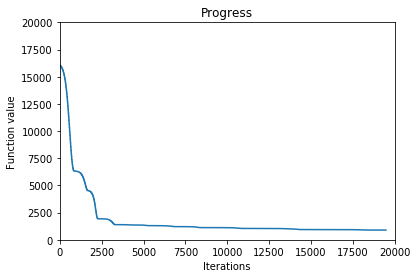

In [53]:
# From Seb_workspace 

def df_s(keep_top=None):
    global df
    global decade_list

    filename = 'imdb.csv'

    df = gen_df(filename)

    decade_list = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

    # Decade dummies
    for i in decade_list:
        df[f'decade_{i}'] = 0
        df.loc[(df['decade'] == f'{i}s'),f'decade_{i}'] = 1

    df = df.loc[(df['ratingCount']>=5000)]
    df.drop(columns=['Adult','GameShow','News','RealityTV','TalkShow'], inplace=True)

    if keep_top != None:
        df = df.sort_values('imdbRating', ascending=False)
        df = df.iloc[:keep_top]

    df_X = df.copy()
    df_Y = pd.DataFrame(df['imdbRating'].copy())
    df_Y.rename(columns = {'imdbRating':'rat_data'}, inplace=True)

    drops = ['index', 'tid', 'title', 'imdbRating', 'ratingCount', 'year', 
             'nrOfGenre', 'nrOfPhotos', 'nrOfNewsArticles',  'nrOfUserReviews', 'decade']

    for i in drops:
        df_X.drop(columns=[i], inplace=True)

    # Rearrange columns
    df_X = df_X.reindex(['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
                              'Drama','Family','Fantasy','FilmNoir','History','Horror','Music','Musical',
                              'Mystery','Romance','SciFi','Short','Sport','Thriller','War','Western',
                              'decade_1920','decade_1930','decade_1940','decade_1950','decade_1960',
                              'decade_1970','decade_1980','decade_1990','decade_2000','decade_2010',
                              'nrOfNominations','nrOfWins','duration'], axis=1)
    
    return df_X, df_Y




def optimizer(keep_top=None):
    global fs
    global evals
    global x0
    global df
    
    def sqr_diff_sum(df_X,pars):
        util = df_X@pars
        df_Y['rat_model'] = 10*np.exp(util)/(1+np.exp(util))
        df_Y['sqr_diff'] = (df_Y['rat_model']-df_Y['rat_data'])**2
        return df_Y['sqr_diff'].sum()

    # Scipy minimize
    def zeros(n): 
        list = [0] * n
        return list 

    def collect(x):
        global fs
        global evals
        global x0
        global fig
        global ax
        global x_1 
        global x_2 
        global x_3 
        global x_4
        global x_5 
        global x_6 
        global x_7 
        global x_8
        global x_9 
        global x_10
        global x_11 
        global x_12 
        global x_13 
        global x_14
        global x_15 
        global x_16 
        global x_17 
        global x_18
        global x_19 
        global x_20
        global x_21 
        global x_22 
        global x_23 
        global x_24
        global x_25 
        global x_26 
        global x_27 
        global x_28
        global x_29 
        global x_30
        global x_31 
        global x_32 
        global x_33 
        global x_34
        global x_35 
        global x_36 
        # for i in range(1,37,1): 
            # global x_i

        if evals == 0:
            fs = []
            fs.append(obj_fun(x0))
            x_1 = [x0[0]] 
            x_2 = [x0[1]]
            x_3 = [x0[2]] 
            x_4 = [x0[3]]
            x_5 = [x0[4]] 
            x_6 = [x0[5]]
            x_7 = [x0[6]] 
            x_8 = [x0[7]]
            x_9 = [x0[8]] 
            x_10 = [x0[9]]
            x_11 = [x0[10]] 
            x_12 = [x0[11]]
            x_13 = [x0[12]] 
            x_14 = [x0[13]]
            x_15 = [x0[14]] 
            x_16 = [x0[15]]
            x_17 = [x0[16]] 
            x_18 = [x0[17]]
            x_19 = [x0[18]] 
            x_20 = [x0[19]]
            x_21 = [x0[20]] 
            x_22 = [x0[21]]
            x_23 = [x0[22]] 
            x_24 = [x0[23]]
            x_25 = [x0[24]] 
            x_26 = [x0[25]]
            x_27 = [x0[26]] 
            x_28 = [x0[27]]
            x_29 = [x0[28]] 
            x_30 = [x0[29]]
            x_31 = [x0[30]] 
            x_32 = [x0[31]]
            x_33 = [x0[32]] 
            x_34 = [x0[33]]
            x_35 = [x0[34]] 
            x_36 = [x0[35]]
        elif evals < 5 and evals != 0:
            print(f'Iteration {evals:6.0f}: Function value = {obj_fun(x):9.2f}')
            time.sleep(.5)
        elif evals == 5:
            print(f'Iteration {evals:6.0f}: Function value = {obj_fun(x):9.2f}')
            print('...')
        elif evals%1000 == 0:
            print(f'Iteration {evals:6.0f}: Function value = {obj_fun(x):9.2f}')

        fs.append(obj_fun(x))
        x_1.append(x[0])
        x_2.append(x[1])
        x_3.append(x[2])
        x_4.append(x[3])
        x_5.append(x[4])
        x_6.append(x[5])
        x_7.append(x[6])
        x_8.append(x[7])
        x_9.append(x[8])
        x_10.append(x[9])
        x_11.append(x[10])
        x_12.append(x[11])
        x_13.append(x[12])
        x_14.append(x[13])
        x_15.append(x[14])
        x_16.append(x[15])
        x_17.append(x[16])
        x_18.append(x[17])
        x_19.append(x[18])
        x_20.append(x[19])
        x_21.append(x[20])
        x_22.append(x[21])
        x_23.append(x[22])
        x_24.append(x[23])
        x_25.append(x[24])
        x_26.append(x[25])
        x_27.append(x[26])
        x_28.append(x[27])
        x_29.append(x[28])
        x_30.append(x[29])
        x_31.append(x[30])
        x_32.append(x[31])
        x_33.append(x[32])
        x_34.append(x[33])
        x_35.append(x[34])
        x_36.append(x[35])
        evals += 1
        
    df_X, df_Y = df_s(keep_top)
    x0 = zeros(36)
    evals = 0
    
    obj_fun = lambda x: sqr_diff_sum(df_X,x)
        
    result = optimize.minimize(obj_fun,x0,
                               method="Nelder-Mead",
                               options={"disp":True, "maxiter":50000}, # display the results
                               callback=collect
                               ) 
    
    # Progress figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('Progress')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Function value')
    ax.set_xlim(0,20000)
    ax.set_ylim(0,20000)
    ax.plot(range(evals+1),fs)
    plt.show()
    
    return result

result = optimizer(keep_top=2000)

result.x

variables = ['Action','Adventure','Animation','Biography','Comedy','Crime','Documentary',
                          'Drama','Family','Fantasy','FilmNoir','History','Horror','Music','Musical',
                          'Mystery','Romance','SciFi','Short','Sport','Thriller','War','Western',
                          'decade_1920','decade_1930','decade_1940','decade_1950','decade_1960',
                          'decade_1970','decade_1980','decade_1990','decade_2000','decade_2010',
                          'nrOfNominations','nrOfWins','duration']

results = dict()

for j,i in enumerate(variables):
    results[i] = result.x[j]
    

In [54]:
results = dict()

for j,i in enumerate(variables):
    results[i] = result.x[j]

    
# Dictionary with parameters 
preben = dict()
for j,i in enumerate(liste):
    preben[i] = f'{result.x[j]:.2f}'
    
print(preben)

{'Action': '-0.33', 'Adventure': '-0.21', 'Animation': '0.40', 'Biography': '-0.09', 'Comedy': '-0.04', 'Crime': '0.02', 'Documentary': '0.16', 'Drama': '0.13', 'Family': '-0.07', 'Fantasy': '0.41', 'FilmNoir': '-0.11', 'History': '-0.37', 'Horror': '0.30', 'Music': '-0.22', 'Musical': '0.13', 'Mystery': '-0.09', 'Romance': '0.06', 'SciFi': '-0.07', 'Short': '-0.18', 'Sport': '-0.06', 'Thriller': '0.07', 'War': '-0.19', 'Western': '-0.51', 'decade_1920': '-0.03', 'decade_1930': '-0.12', 'decade_1940': '0.04', 'decade_1950': '0.10', 'decade_1960': '0.14', 'decade_1970': '-0.01', 'decade_1980': '0.40', 'decade_1990': '0.09', 'decade_2000': '0.10', 'decade_2010': '0.13', 'nrOfNominations': '-0.00', 'nrOfWins': '0.00', 'duration': '0.58'}


In [55]:
parameters = [x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10,
              x_11, x_12, x_13, x_14, x_15, x_16, x_17, x_18, x_19, x_20,
              x_21, x_22, x_23, x_24, x_25, x_26, x_27, x_28, x_29, x_30,
              x_31, x_32, x_33, x_34, x_35, x_36]

par_dict = {"Action": x_1,
             "Adventure": x_2,
             "Animation": x_3,
             "Biography": x_4,
             "Comedy": x_5,
             "Crime": x_6,
             "Documentary": x_7,
             "Drama": x_8, 
             "Family": x_9,
             "Fantasy": x_10,
             "Film Noir": x_11,
             "History": x_12,
             "Horror": x_13,
             "Music": x_14,
             "Musical": x_15,
             "Mystery": x_16,
             "Romance": x_17,
             "SciFi": x_18, 
             "Short": x_19,
             "Sport": x_20,
             "Thriller": x_21,
             "War": x_22,
             "Western": x_23,
             "1920's": x_24,
             "1930's": x_25,
             "1940's": x_26,
             "1950's": x_27,
             "1960's": x_28,
             "1970's": x_29,
             "1980's": x_30,
             "1990's": x_31,
             "2000's": x_32,
             "2010's": x_33,
             "Nr. of Nominations": x_34, 
             "Nr. of Wins": x_35, 
             "Duration": x_36
            }

df_par = pd.DataFrame(par_dict)

In [56]:
# Interactive graph of parametervalues for each iteration in optimizer 
## Interactive: Chose which parameter to show 

parameters = [x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10,
              x_11, x_12, x_13, x_14, x_15, x_16, x_17, x_18, x_19, x_20,
              x_21, x_22, x_23, x_24, x_25, x_26, x_27, x_28, x_29, x_30,
              x_31, x_32, x_33, x_34, x_35, x_36]


# Interactive graph of parameter estimates
def graph(par):
    plt.plot(df_par[par])
    plt.grid(True)
    plt.axhline(df_par[par].iloc[-1], linestyle="dashed", color="orange", label="Optimum")
    
    # Labels 
    plt.title("Progress in Parameter Estimation")
    plt.ylabel("Parameter Estimate")
    plt.xlabel("Nr. of Iterations")
    plt.legend()

    
def graph_int(): 
    widgets.interact(graph, 
                     par = widgets.Dropdown( 
                     description="Variable", 
                     options=df_par.columns.values, 
                     value="Action"));
graph_int()


interactive(children=(Dropdown(description='Parameter', options=('Action', 'Adventure', 'Animation', 'Biograph…